<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Autoencoder%20Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Benchmark

## Import dependencies for Google Colab

In [ ]:
! git clone https://github.com/nahumsa/DM-Reconstruction

In [ ]:
!pip install qutip

In [ ]:
% cd DM-Reconstruction/

## Import Dependencies

In [68]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

import numpy as np
from tensorflow.keras import layers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [44]:
%load_ext autoreload
%autoreload 2

## Creating Dataset

In [46]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

In [47]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)


## Model

In [93]:
class Encoder(layers.Layer):
    """Maps Input to latent dimension."""

    def __init__(self,
                latent_dim,
                intermediate_dim,
                dropout_rate,
                **kwargs):
      
      super(Encoder, self).__init__(**kwargs)
      self.dense_proj = []
      for i in intermediate_dim:        
        self.dense_proj.append(layers.Dense(i,
                                            activation=tf.nn.relu))
      
      self.dropout_rate = dropout_rate
      
      if self.dropout_rate:
        self.dropout = layers.Dropout(self.dropout_rate)

      self.latent_layer = layers.Dense(latent_dim)    

    def call(self, inputs):
      x = self.dense_proj[0](inputs)
      
      for lay in self.dense_proj[1:]:
        x = lay(x)
        if self.dropout_rate:
          x = self.dropout(x)
          
      return self.latent_layer(x)

class Decoder(layers.Layer):
  """Decodes the encoded representation of the Encoder."""

  def __init__(self,
               original_dim,
               intermediate_dim,
               dropout_rate=None,
               **kwargs):
    super(Decoder, self).__init__(**kwargs)

    self.dense_proj = []
    for i in reversed(intermediate_dim):      
      self.dense_proj.append(layers.Dense(i,
                                          activation=tf.nn.relu))
    
    self.dropout_rate = dropout_rate
    
    if self.dropout_rate:
      self.dropout = layers.Dropout(self.dropout_rate)

    self.dense_output = layers.Dense(original_dim)

  def call(self, inputs):
    x = self.dense_proj[0](inputs)
    
    for lay in self.dense_proj[1:]:
      x = lay(x)
      if self.dropout_rate:
        x = self.dropout(x)

    return self.dense_output(x)

class AutoEncoder(tf.keras.Model):
  """ AutoEncoder Model.

  Parameters
  -----------------------------------
  original_dim(int): Dimension of the input.
  intermediate_dim(list): Number of neurons on intermediate layers.
  latent_dim(int): Latent dimension.
  dropout_rate(float): Percentage of dropout.

  """

  def __init__(self,
               original_dim,
               intermediate_dim,
               latent_dim,
               dropout_rate,       
               **kwargs):
    super(AutoEncoder, self).__init__()    
    self.encoder = Encoder(latent_dim=latent_dim, 
                           dropout_rate=dropout_rate,
                           intermediate_dim= intermediate_dim)
    self.decoder = Decoder(original_dim, 
                           dropout_rate= dropout_rate,
                           intermediate_dim= intermediate_dim)    
    self.fidelity = []
  
  def call(self, inputs):
    z = self.encoder(inputs)
    reconstructed = self.decoder(z)    
    return reconstructed

  def train_step(self, data):
    x, y = data 
    
    with tf.GradientTape() as tape:
      # Forward Pass
      y_pred = self(x, training=True)

      # Compute Loss Function
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
    
    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(y, y_pred)
    
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}  

  def test_step(self, data):
    # Unpack the data
    x, y = data
    # Compute predictions
    y_pred = self(x, training=False)
    # Updates the metrics tracking the loss
    self.compiled_loss(y, y_pred, regularization_losses=self.losses)
    # Update the metrics.
    self.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value.
    # Note that it will include the loss (tracked in self.metrics).         
    return {m.name: m.result() for m in self.metrics}


In [94]:
latent_dim = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

AE = AutoEncoder(original_dim=input_dim, 
            intermediate_dim= hidden_dims,
            latent_dim=latent_dim,
            dropout_rate=dropout_rate)

AE.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
epochs = 10
history = AE.fit(x=X_train,
                 y=X_train, 
                 epochs=epochs,                                                                                   
                 validation_data=(X_test,X_test)
                )

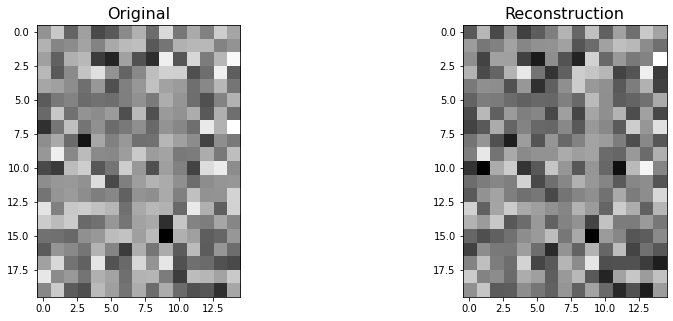

In [96]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.imshow((X_test[0:20]), cmap="gray")
ax1.set_title('Original', size=16)

ax2.imshow(AE.predict(X_test[0:20]), cmap="gray")
ax2.set_title('Reconstruction', size=16)

plt.show()

In [97]:
from Utils.QMetrics import fidelity_rho

fid = []
for val_1, val_2 in zip(X_test, AE.predict(X_test)):
  fid.append(fidelity_rho(val_1,val_2))

np.mean(fid)

0.9572691240045957